#  Modelling sine function with jax 

- xavier glorot uniform init (higher output dim gives smaller uniform range)
- pytrees jax 
- 

Following:
https://www.youtube.com/watch?v=Oieh4YFZZz0&ab_channel=MachineLearning%26Simulation


In [1]:
import jax
import jax,numpy as jnp 
import matplotlib.pyplot as plt 

In [2]:
N_SAMPLES = 200
LAYERS = [1,10,10,10,1]
LEARNING_RATE = 0.1
N_EPOCHS = 30_000

In [3]:
key = jax.random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
keyy, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi)
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.3

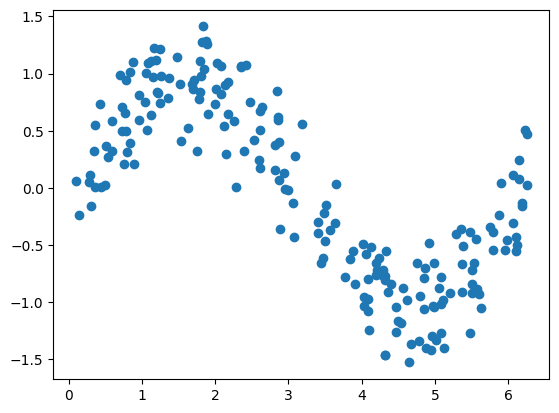

In [5]:
plt.scatter(x_samples, y_samples)

In [6]:
# weight init w glorot uniform
weight_matrices = []
bias_vectors = []
activation_functions = []
for (fan_in, fan_out) in zip(LAYERS[:-1], LAYERS[1:]):
    kernel_matrix_uniform_limit = jnp.sqrt(6 / (fan_in + fan_out))
    key , wkey = jax.random.split(key)
    W = jax.random.uniform(
        wkey, 
        (fan_in, fan_out), 
        minval=-kernel_matrix_uniform_limit, 
        maxval=kernel_matrix_uniform_limit
    )
    b = jnp.zeros(fan_out)
    weight_matrices.append(W)
    bias_vectors.append(b)
    activation_functions.append(jax.nn.sigmoid)
activation_functions[-1] = lambda x: x

forward pass

In [7]:
for w in weight_matrices:
    print(w.shape)

(1, 10)
(10, 10)
(10, 10)
(10, 1)


In [8]:
x_samples.shape

(200, 1)

In [9]:
def network_forward(x, weights, biases, activations):
    a = x
    for W,b,f in zip(weights, biases,activations):
        a = f(a @ W  + b)
    return a

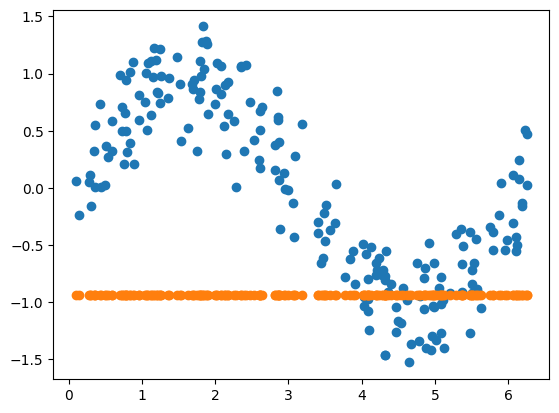

In [10]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))

In [11]:
def loss_forward(y_pred, y_true):
    delta = y_pred - y_true
    return 0.5 * jnp.mean(delta ** 2) 

In [12]:
loss_forward(
    network_forward(x_samples, weight_matrices, bias_vectors, activation_functions),
    y_samples
)

Array(0.70622885, dtype=float32)

## AUtodiff w jax

Lambda is a closure which captures the enviroment 

In [13]:
loss_and_grad_fun = jax.value_and_grad(
    lambda Ws, bs: loss_forward(
        network_forward(
            x_samples, Ws, bs, activation_functions
        ),
        y_samples
    ),
    argnums=(0,1) # which grads to track
)

In [14]:
initial_loss, (init_w_grad, init_bias_grad) = loss_and_grad_fun(weight_matrices, bias_vectors)

In [15]:
initial_loss

Array(0.70622885, dtype=float32)

Check inital loss is same as primal execution above

In [17]:
# would be really slow, use jit instead 
loss_and_grad_fun = jax.jit(loss_and_grad_fun)

In [18]:
# Training loop - jax does not allow array mutation
loss_history = []
for epoch in range(N_EPOCHS):
    loss, (w_grad, b_grad) = loss_and_grad_fun(
        weight_matrices,
        bias_vectors,
    )
    # update is bit odd bc jax does not allow array mutation
    weight_matrices = jax.tree_map( # PYTREE = collection of matrices that jax understands. 
        lambda W, W_grad: W - LEARNING_RATE * W_grad,
        weight_matrices,
        w_grad
    )
    bias_vectors = jax.tree_map( # PYTREE = collection of matrices that jax understands. 
        lambda b, b_grad: b - LEARNING_RATE * b_grad,
        bias_vectors,
        b_grad
    )
    
    if epoch % 1000 == 0:
        print(f"epoch = {epoch} loss={loss}")
        
    loss_history.append(loss)

epoch = 0 loss=0.7062288522720337
epoch = 1000 loss=0.14338840544223785
epoch = 2000 loss=0.1228010505437851
epoch = 3000 loss=0.11119803786277771
epoch = 4000 loss=0.09983410686254501
epoch = 5000 loss=0.08950752764940262
epoch = 6000 loss=0.07981749624013901
epoch = 7000 loss=0.07275664806365967
epoch = 8000 loss=0.06897575408220291
epoch = 9000 loss=0.0659215971827507
epoch = 10000 loss=0.0626450628042221
epoch = 11000 loss=0.05897677317261696
epoch = 12000 loss=0.05491676181554794
epoch = 13000 loss=0.051014840602874756
epoch = 14000 loss=0.04766127094626427
epoch = 15000 loss=0.04496657848358154
epoch = 16000 loss=0.04291520640254021
epoch = 17000 loss=0.041438307613134384
epoch = 18000 loss=0.04042421281337738
epoch = 19000 loss=0.039748240262269974
epoch = 20000 loss=0.039303623139858246
epoch = 21000 loss=0.03901110216975212
epoch = 22000 loss=0.03881622850894928
epoch = 23000 loss=0.038683388382196426
epoch = 24000 loss=0.03859004005789757
epoch = 25000 loss=0.0385222919285297

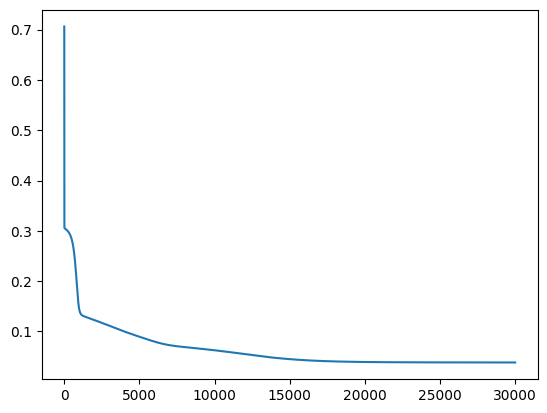

In [19]:
import numpy as np
plt.plot(np.arange(N_EPOCHS), loss_history)

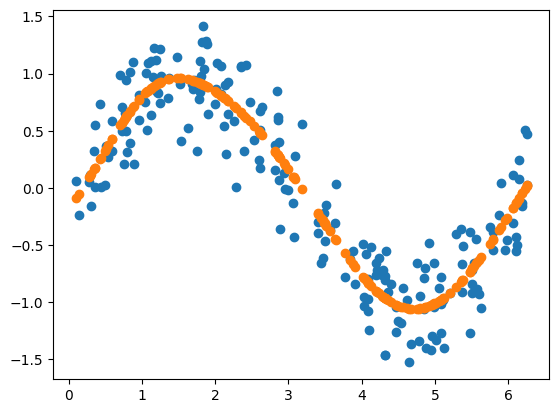

In [20]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))